In [1]:
import datasets
import numpy as np
import torch
from transformers import AutoTokenizer
from datasets import load_dataset

from pathlib import Path
import sys

project_root = Path.cwd().parent  # adjust if llms-entropy isn’t directly under the project root
sys.path.append(str(project_root / "gpt-circuits"))

from model import GPT, GPTConfig
import utils

/scratch/gpfs/WBIALEK/ls1546/.conda/envs/gpt-circuits/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# download 2025-01 through 2025-06
ds = []
for month in range(1, 7):
    month_str = f'{month:02d}'
    ds.append(datasets.load_dataset('RealTimeData/bbc_news_alltime', f'2025-{month_str}'))

Using the latest cached version of the dataset since RealTimeData/bbc_news_alltime couldn't be found on the Hugging Face Hub (offline mode is enabled).
Found the latest cached dataset configuration '2025-01' at /scratch/gpfs/WBIALEK/ls1546/.cache/huggingface/datasets/RealTimeData___bbc_news_alltime/2025-01/0.0.0/8dd1ecdc92ac43f9c04a3da3e945537dbb08179b (last modified on Fri Nov  7 11:03:54 2025).
Using the latest cached version of the dataset since RealTimeData/bbc_news_alltime couldn't be found on the Hugging Face Hub (offline mode is enabled).
Found the latest cached dataset configuration '2025-02' at /scratch/gpfs/WBIALEK/ls1546/.cache/huggingface/datasets/RealTimeData___bbc_news_alltime/2025-02/0.0.0/8dd1ecdc92ac43f9c04a3da3e945537dbb08179b (last modified on Fri Nov  7 11:04:56 2025).
Using the latest cached version of the dataset since RealTimeData/bbc_news_alltime couldn't be found on the Hugging Face Hub (offline mode is enabled).
Found the latest cached dataset configuration '2

In [ ]:
# extract the train split texts(that's all there is)
texts = [ds[i]['train']['content'] for i in range(len(ds))]
len(texts), len(texts[0]), len(texts[1])

(6, 394, 2747)

In [18]:
len(texts), len(texts[0]), len(texts[1]), len(texts[2]), len(texts[3]), len(texts[4]), len(texts[5])

(6, 394, 2747, 2697, 2571, 2704, 2671)

In [5]:
all_texts = [texts[i][j] for i in range(len(texts)) for j in range(len(texts[i]))]
len(all_texts)

13784

In [6]:
# calculate entropy and codelengths over multiple files from C4 dataset
out_dir = '/scratch/gpfs/WBIALEK/ls1546/gpt-circuits/out/shard1_m1337_d1337/'
model_ckpt = f'{out_dir}1756086913.6403742_ckpt_47000.pt'
init_from = 'scratch'

# model
dropout = 0.0
bias = False
backend = 'nccl'
device = 'cuda'
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
block_size = 2048
n_layer = 24
n_head = 16
n_embd = 2048
z_loss = 1e-4

# load model checkpoint and see if inference output is reasonable
checkpoint = torch.load(model_ckpt, map_location=device)
checkpoint_model_args = checkpoint['model_args']
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=50277, dropout=dropout, z_loss=z_loss) # start with model_args from command line

for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
    model_args[k] = checkpoint_model_args[k]
# create the model
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)

tok_model = "EleutherAI/gpt-neox-20b"
seqlen=2048
tokenizer = AutoTokenizer.from_pretrained(tok_model, use_fast=True)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
model.load_state_dict(state_dict)
model.to(device)
model.eval();

number of parameters: 1713.78M


In [15]:
# calculate entropy
# # just do the first 680 batches which takes 1hr
# # 680*16=10880 entries
quarter_texts = all_texts[:len(all_texts)//4]
first_100_batches = all_texts[:1600]
total_entropy, total_tokens, pos_sum_ent, pos_count_ent = utils.calc_entropy(
    first_100_batches, model, tokenizer, seqlen, device, batch_size=16)
dataset_avg_entropy = total_entropy / total_tokens
print(f'Dataset Average Entropy (bits/token): {dataset_avg_entropy:.4f}')
per_position_avg_ent = pos_sum_ent / pos_count_ent.clamp_min(1)
print(f'Per-position avg entropy shape: {per_position_avg_ent.shape}')

# save results
results_ent = {}
results_ent['total_entropy'] = total_entropy
results_ent['total_tokens'] = total_tokens
results_ent['pos_sum_ent'] = pos_sum_ent.numpy()
results_ent['pos_count_ent'] = pos_count_ent.numpy()
np.save('ent_and_codelen_results/ent_results_news.npy', results_ent)

avg entropy (bits): 3.7239: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:15<00:00,  5.55s/it]


Dataset Average Entropy (bits/token): 3.7239
Per-position avg entropy shape: torch.Size([2047])


FileNotFoundError: [Errno 2] No such file or directory: 'ent_and_codelen_results/ent_results_news.npy'

In [16]:
np.save('ent_and_codelen_results/ent_results_news.npy', results_ent)

In [17]:
total_codelengths, total_tokens, pos_sum_codelen, pos_count_codelen = utils.calc_codelength(
    first_100_batches, model, tokenizer, seqlen, device, batch_size=16)
dataset_avg_codelen = total_codelengths / total_tokens
print(f'Dataset Average Codelength (bits/token): {dataset_avg_codelen:.4f}')
per_position_avg_codelen = pos_sum_codelen / pos_count_codelen.clamp_min(1)
print(f'Per-position avg codelen shape: {per_position_avg_codelen.shape}')

# save results
results_codelen = {}
results_codelen['total_codelengths'] = total_codelengths
results_codelen['total_tokens'] = total_tokens
results_codelen['pos_sum_codelen'] = pos_sum_codelen.numpy()
results_codelen['pos_count_codelen'] = pos_count_codelen.numpy()
np.save('ent_and_codelen_results/codelen_results_news.npy', results_codelen)

avg codelength (bits): 3.7823: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:12<00:00,  5.53s/it]

Dataset Average Codelength (bits/token): 3.7823
Per-position avg codelen shape: torch.Size([2047])


In [2]:
# load c4 data as well and plot on same graph
results_ent_c4 = np.load('ent_and_codelen_results/ent_results.npy', allow_pickle=True).item()
results_codelen_c4 = np.load('ent_and_codelen_results/codelen_results.npy', allow_pickle=True).item()
results_ent_news = np.load('ent_and_codelen_results/ent_results_news.npy', allow_pickle=True).item()
results_codelen_news = np.load('ent_and_codelen_results/codelen_results_news.npy', allow_pickle=True).item()

In [3]:
per_position_avg_ent_c4 = results_ent_c4['pos_sum_ent'] / results_ent_c4['pos_count_ent']
per_position_avg_codelen_c4 = results_codelen_c4['pos_sum_codelen'] / results_codelen_c4['pos_count_codelen']
per_position_avg_ent_news = results_ent_news['pos_sum_ent'] / results_ent_news['pos_count_ent']
per_position_avg_codelen_news = results_codelen_news['pos_sum_codelen'] / results_codelen_news['pos_count_codelen']

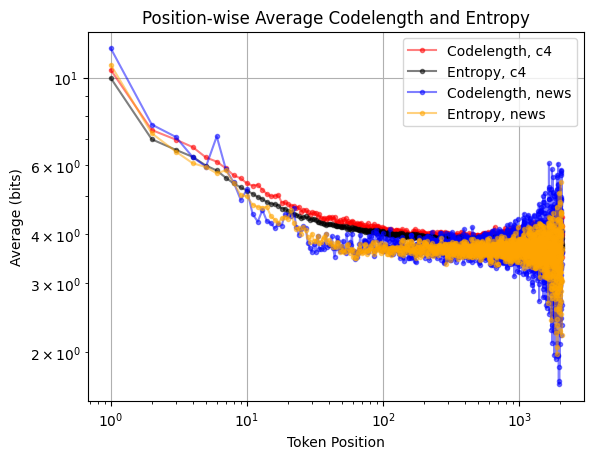

In [4]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, len(per_position_avg_codelen_c4)+1), per_position_avg_codelen_c4, marker='.', label='Codelength, c4', color='red', alpha=0.5)
plt.plot(np.arange(1, len(per_position_avg_ent_c4)+1), per_position_avg_ent_c4, marker='.', label='Entropy, c4', color='black', alpha=0.5)
plt.plot(np.arange(1, len(per_position_avg_codelen_news)+1), per_position_avg_codelen_news, marker='.', label='Codelength, news', color='blue', alpha=0.5)
plt.plot(np.arange(1, len(per_position_avg_ent_news)+1), per_position_avg_ent_news, marker='.', label='Entropy, news', color='orange', alpha=0.5)
plt.title('Position-wise Average Codelength and Entropy')
plt.xlabel('Token Position')
plt.ylabel('Average (bits)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.legend()
# plt.savefig(save_path)

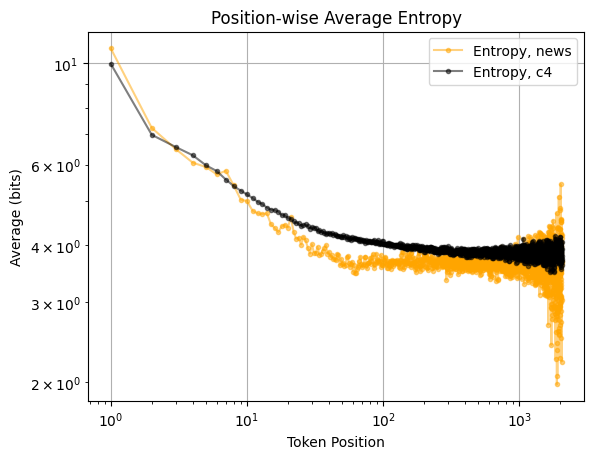

In [6]:
# plt.plot(np.arange(1, len(per_position_avg_codelen_c4)+1), per_position_avg_codelen_c4, marker='.', label='Codelength, c4', color='red', alpha=0.5)
plt.plot(np.arange(1, len(per_position_avg_ent_news)+1), per_position_avg_ent_news, marker='.', label='Entropy, news', color='orange', alpha=0.5)
plt.plot(np.arange(1, len(per_position_avg_ent_c4)+1), per_position_avg_ent_c4, marker='.', label='Entropy, c4', color='black', alpha=0.5)
# plt.plot(np.arange(1, len(per_position_avg_codelen_news)+1), per_position_avg_codelen_news, marker='.', label='Codelength, news', color='blue', alpha=0.5)

plt.title('Position-wise Average Entropy')
plt.xlabel('Token Position')
plt.ylabel('Average (bits)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.legend()

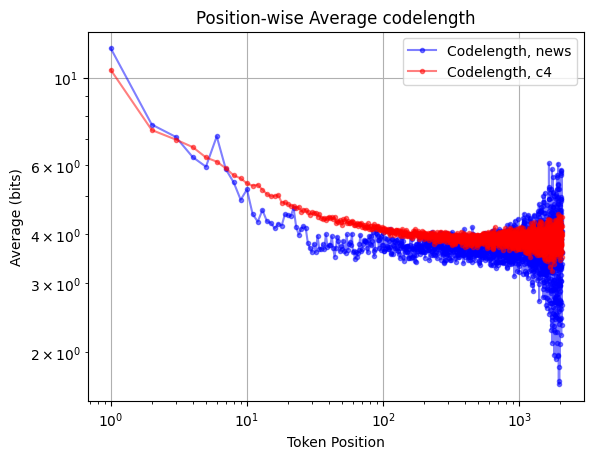

In [7]:
plt.plot(np.arange(1, len(per_position_avg_codelen_news)+1), per_position_avg_codelen_news, marker='.', label='Codelength, news', color='blue', alpha=0.5)
plt.plot(np.arange(1, len(per_position_avg_codelen_c4)+1), per_position_avg_codelen_c4, marker='.', label='Codelength, c4', color='red', alpha=0.5)
# plt.plot(np.arange(1, len(per_position_avg_ent_news)+1), per_position_avg_ent_news, marker='.', label='Entropy, news', color='orange', alpha=0.5)
# plt.plot(np.arange(1, len(per_position_avg_ent_c4)+1), per_position_avg_ent_c4, marker='.', label='Entropy, c4', color='black', alpha=0.5)


plt.title('Position-wise Average codelength')
plt.xlabel('Token Position')
plt.ylabel('Average (bits)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.legend()